Big Data And Society: Lab 3
=====


# APIs and Data Scraping: Getting Twitter Data

### 0. Set up a Twitter Application

This week we are going to scrape data from the Twitter API and make some plots! We are going to use the Twitter REST API, which lets us query and retreive samples of Tweets. To do this, you need API keys that are associated with your account. Your API keys are secret and unique to you and only you, and they gives you access to Twitter data through the API.

There are a couple of ways to get Twitter data, the REST API is just one of them. The others are to set up a Streamer (which streams real time tweets), or to access the Firehose (this means everything!). Read [this article](https://brightplanet.com/2013/06/twitter-firehose-vs-twitter-api-whats-the-difference-and-why-should-you-care/) for a nice comparison between the methods.

The Twitter REST API is best place to start and what we will use in class. Follow the following steps to get your keys.

* Create a twitter account if you do not already have one.
* Go to [https://apps.twitter.com/](https://apps.twitter.com/) and log in with your twitter credentials.
* Click **"Create New App"** in the upper right corner
* Fill out the form, give it a name like **data_getter_yourname** and a description, agree to the terms, and click **"Create your Twitter application"** *Note: The form will ask for a website. You can put the github.io page you made as the URL. **It is OK for your callback URL to be blank.***
* In the next page, click on **Keys and Access Tokens** tab, and copy your "Consumer Key (API Key)" and "Consumer Key (API Secret)".

We need a Python file that will contain the **Twitter** keys. It is never a good idea to host these keys on a public website like **github**, so one way to keep them private is importing the keys as a variable from a separate, untracked file. Open your text editor, and in the materials for the week, *PASTE* these keys into the **twitter-keys.py** file and save the file. Using this method, we can then import the keys and use them on a repeated basis, and we can choose not to put this file on Github. **Make sure they are saved as strings!**

**!!IMPORTANT NOTE!! NEVER SAVE YOUR TWITTER_KEY.PY FILE TO GITHUB. IF YOU DO, PEOPLE CAN SEE YOUR KEYS AND USE THEM. KEEP THESE ON YOUR MACHINE.**

### 1. Importing the Libraries and Twitter Keys

We will be using **Twython**, a Python library that provides wrappers around Twitter's API. To install **Twython** on a terminal or the command line, run the following command:

```
pip install twython
```

We also need to import the keys we just got from Twitter to be accessible to our code. View the contents of **twitter_key.py** to see your keys. These should both be strings.

```
# In the file you should define two variables:
api_key = "your twitter key"
api_secret = "your twitter secret"
```

Import the libraries:



In [2]:
# Import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import api_key, api_secret

### 2. Set Up Twython, Get an OAuth2 Token, and Create your Twython Object

In this next step, assign the keys to variables and set up our instance of Twython to work with your account.

Doing this requires our authentication with Twitter using our keys. Twitter uses something called [OAuth](https://dev.twitter.com/oauth) for API authentication. There are two types of OAuth authentication. OAuth1 provides user authentication to the API, and is required to post tweets and issue requests on behalf of users. OAuth 2 is [application-only authentication](https://dev.twitter.com/oauth/application-only), and has higher rate limits but doesn't allow you to post on users behalf. Because we can get more tweets using it, we are going to use OAuth2. 

**OAuth 2 requires a Third Access token you must request using the API. This next step will set everything up for us.**

In the last part of this, we create a **Twython** object and call it **my_twython**; this object simplifies the access to the [Twitter API](https://dev.twitter.com/overview/documentation), and provides methods for accessing the API’s endpoints. The first function fetches tweets with a given query at a given lat-long. We will be using the search parameters to hit the APIs endpoint. We need to provide the lat/lon of the centroid of the area we want to query, maximum number of tweets to return, and area within the centroid to search for, among others.

In [3]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

For reference, the Twython documentation and all available commands can be found here. [https://twython.readthedocs.io/en/latest/usage/starting_out.html](https://twython.readthedocs.io/en/latest/usage/starting_out.html)

### 3. Query the Twitter API to get Tweets at a Location

Next, let's do a search and get some tweets! Specifically, set up a function that will use the **search** API. Read more about the **search** API [here](https://dev.twitter.com/rest/reference/get/search/tweets).

The **Search API** can take many parameters for querying tweets. Twitter has a nice page of what you can use as query parameters here [https://dev.twitter.com/rest/public/search](https://dev.twitter.com/rest/public/search).

The Twitter API has rate limits that limit how quickly you can download data. This is to try to lighten the load on their servers. We are using the Search API with **OAuth2 (Application) Access** - which limits us to **450 in 15 minutes** Read about the [Rate Limits](https://dev.twitter.com/rest/public/rate-limiting) here. This means, in our following steps, always follow the guideline that you will not be able to get more than 450 tweets in 15 minutes, or Twitter might lock your access.

In [3]:
# Input the search term you want to search on
search_term='energy' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[40.261455,-76.882553] # Downtown Harrisburg, PA - Capital of Pennsylvania
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=15


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Wed Mar 01 15:31:52 +0000 2017',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [{'display_url': 'fb.me/38d36LOwP',
     'expanded_url': 'http://fb.me/38d36LOwP',
     'indices': [114, 137],
     'url': 'https://t.co/VgslZ4xXQt'}],
   'user_mentions': []},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 836962196328484864,
  'id_str': '836962196328484864',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'place': None,
  'possibly_sensitive': False,
  'retweet_count': 0,
  'retweeted': False,
  'source': '<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>',
  'text': "Haven't shared this in a while...long read, but quite helpful!\n\nTips to

### 4. Automate it - Hit the API and Parse the Result

We are going to create a function to help us repeatedly hit the API, and parse the result into a readable JSON that contains the things that we are interested in, and still stores the raw tweet as an additional property. The returned object is a Python `dict` that we can easily parse into another dictionary to later store as a JSON. Raw JSONs returned from the API have a specific structure.

It can be sometimes hard to read a raw JSON. I find it easy to use some online parsers like [this]( http://jsonparseronline.com/) to look at the structure of the JSON, and only access what we care about.

Note: Remember we are limited to 450 every 15 minutes.

In [4]:
# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 10
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 5
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

### 5. Run the Twitter Scraper

We need to call the functions, and save the JSONs into a location. In this case, I made a folder called **data**, where I am saving all the new JSONS. We can run the code continuously utilizing some loop, or we can use libraries like [threading](https://docs.python.org/3.6/library/threading.html).

*Make sure you have a folder named **data** in the directory with your notebook! This function will save our collected datafiles to it when it finishes running.*

In [5]:
# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 15 new tweets, for a total of 15
At 5 seconds, added 0 new tweets, for a total of 15
15 Tweets retrieved.


### 6. Let's Explore the Data we Saved to our Machine

Let's look through the JSON we created and checkout some of the data we just downloaded. First, let's import a couple of additional libraries that will let us interact with our file system, use numpy and pandas, and create plots:

In [4]:
# Import some additional libraries that will allow us to plot and interact with the operating system
from os import listdir #allows us to get files from the computer
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Next, let's explore our data a bit. This following function will allow us to perform a visual examination of what we downloaded from Twitter. Once we have collected some data, we can parse it, and visualize some of the results. Since some of the data is repeated, we can initialize some lists to check whether or not a tweet already exists, and add it to the list. We can then extract the useful information for our purposes, and store it in another list.

Building on last week, we can do this in Pandas.

In [7]:
# Get the file names from a given directory
file_dir = "data" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                
df_tweets

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time
836948705966186496,836948705966186496,None,None,"Energy boom, rail hopes, Trump order stoke Pa....",Harrisburg PA,3001459376,{'created_at': 'Wed Mar 01 14:38:15 +0000 2017...,none,Wed Mar 01 14:38:15 +0000 2017
836929061263929345,836929061263929345,None,None,It takes way too much time &amp; energy to blo...,"Harrisburg, PA",742166459628068864,{'created_at': 'Wed Mar 01 13:20:12 +0000 2017...,none,Wed Mar 01 13:20:12 +0000 2017
836924912539480065,836924912539480065,None,None,"RT @EtownChaplain: #etownleffler great crowd,...","Elizabethtown, PA",45481676,{'created_at': 'Wed Mar 01 13:03:43 +0000 2017...,none,Wed Mar 01 13:03:43 +0000 2017
836924779298967553,836924779298967553,None,None,Canada is the United States largest partner f...,"Harrisburg, PA",30474844,{'created_at': 'Wed Mar 01 13:03:11 +0000 2017...,none,Wed Mar 01 13:03:11 +0000 2017
836912573844959232,836912573844959232,None,None,RT @GeminijlwWilson: After advancing Scott Pru...,,800676192,{'created_at': 'Wed Mar 01 12:14:41 +0000 2017...,none,Wed Mar 01 12:14:41 +0000 2017
836900781026652160,836900781026652160,None,None,RT @jham717: If you are riding a wave of high ...,,826720417373155328,{'created_at': 'Wed Mar 01 11:27:49 +0000 2017...,none,Wed Mar 01 11:27:49 +0000 2017
836898952767242240,836898952767242240,None,None,"After advancing Scott Pruitt confirmation, sen...","Harrisburg, Pa",327022004,{'created_at': 'Wed Mar 01 11:20:33 +0000 2017...,none,Wed Mar 01 11:20:33 +0000 2017
836781856347435008,836781856347435008,None,None,@StephenBannon Build wall out of solar panels;...,"Hershey, PA",2219493676,{'created_at': 'Wed Mar 01 03:35:15 +0000 2017...,none,Wed Mar 01 03:35:15 +0000 2017
836777666665721857,836777666665721857,None,None,Build wall out of solar panels; Largest Green ...,"Hershey, PA",2219493676,{'created_at': 'Wed Mar 01 03:18:36 +0000 2017...,none,Wed Mar 01 03:18:36 +0000 2017
836777580871180288,836777580871180288,None,None,@CNN Build wall out of solar panels; Largest G...,"Hershey, PA",2219493676,{'created_at': 'Wed Mar 01 03:18:16 +0000 2017...,none,Wed Mar 01 03:18:16 +0000 2017


### 7. Summarize, Group, and Plot the Dataset

Next let's summarize and group our data, and create some plots.

**A** - First, group by the user location. This is not lat/lon, but rather the information the individual has input on their profile.

When you give people the power to input their own location, you get an assortment of 'creative' responses!

In [8]:
df_tweets.dtypes

tweet_id      object
lat           object
lon           object
content       object
location      object
user          object
raw_source    object
data_point    object
time          object
dtype: object

In [9]:
df_tweets['location'].unique()

array(['Harrisburg PA', 'Harrisburg, PA', 'Elizabethtown, PA', '',
       'Harrisburg, Pa', 'Hershey, PA', 'Elizabethtown College, PA',
       'Middletown, PA'], dtype=object)

Now let's do some grouping and sorting. We are using Pandas to do our analysis, much like last week.

In [10]:
grouped_tweets = df_tweets.groupby('location')
count_tweets = grouped_tweets['location'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location']
df_count_tweets.sort_index()

,Count
Location,
,2
"Elizabethtown College, PA",1
"Elizabethtown, PA",1
Harrisburg PA,1
"Harrisburg, PA",2
"Harrisburg, Pa",1
"Hershey, PA",7
"Middletown, PA",1


Let's create a pie chart of these using matplotlib.

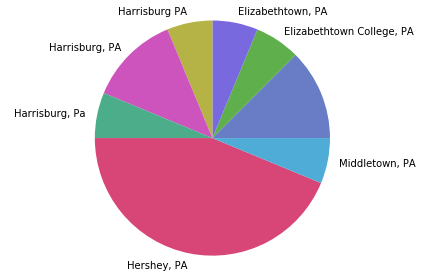

In [11]:
# Create a list of colors (from iWantHue)
colors = ["#697dc6","#5faf4c","#7969de","#b5b246",
          "#cc54bc","#4bad89","#d84577","#4eacd7",
          "#cf4e33","#894ea8","#cf8c42","#d58cc9",
          "#737632","#9f4b75","#c36960"]

# Create a pie chart
plt.pie( df_count_tweets['Count'], labels=df_count_tweets.index.get_values(), shadow=False, colors=colors)

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

There are quite a few duplicates that we can clearly see, you will likely want to clean this data to rectify this.

**B** - Next, let's find how many actually have a location and put them on a scatterplot. To do this, we need to find first the rows where lat and long are not None, and then create the plot from just that subset of the data. Let's give it a go.

In [12]:
# Create a filter from df_tweets filtering only those that have values for lat and lon
df_tweets_with_location = df_tweets[df_tweets.lon.notnull() & df_tweets.lat.notnull()]
df_tweets_with_location

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time


ValueError: First argument must be a sequence

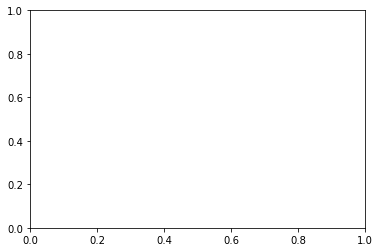

In [13]:
# Use a scatter plot to make a quick visualization of the data points
# NOTE: WHEN I DID THIS, I ONLY HAD SIX OUT OF ABOUT 100 TWEETS!
plt.scatter(df_tweets_with_location['lon'],df_tweets_with_location['lat'], s=25)
plt.show()

### 8. Clean the Data

**Clean the Locations** - You saw above that we had a bunch of locations that were very similar. Here, we could use [replace](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html). For example, we could replace all the variations of **York, PA** with a singular string using something like the following:

In [22]:
# List of variations of York
variations_of_harrisburg = ['Harrisburg PA','Harrisburg, PA','Harrisburg, Pa']
variations_of_elizabethtown = ['Elizabethtown College, PA', 'Elizabethtown, PA']

df_tweets['location'].replace[(variations_of_harrisburg, 'Harrisburg, PA')
#df_tweets['location'].replace(variations_of_elizabethtown, 'Elizabethtown, PA')

SyntaxError: unexpected EOF while parsing (<ipython-input-22-2d8482883144>, line 6)

**Remove Duplicates** - Make sure that we don't get tweets plotted more than once. How would you make sure to only plot unique tweets? We can maybe use [drop_duplicates](http://chrisalbon.com/python/pandas_delete_duplicates.html)

### 9. Exporting your Data to CSV

Exporting your dataset is easy, you can use **to_csv()**. This [Stack Exchange](http://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file) page will help you.

In [23]:
df_tweets.to_csv('twitter_data.csv', sep=',', encoding='utf-8')

### Problem Set 3 - Extend What You Have Learned

Now that you know how to scrape data from Twitter, let's extend the exercise a little so you can show us what you know. This time you will set up the scraper to get data around MIT and scrape data for 30 minutes. Then you will visualize it with  and visualize. Think about what you would need to change to do that. 

Once you have the new JSON file of Boston tweets you should a pie chart and scatterplot of your collected tweets. When you are creating your dataset, you should get at least two different attributes returned by the Twitter API (we got many of them above, so base it off of that example). Atleast one of them should be the tweet id. Make sure you remove and duplicate tweets (if any). Expanding on the above, then save the data to a CSV.

Make sure you get your own Twitter Key.

#### Deliverables

**1** - Using the Twitter REST API, collect Tweets from Boston for 30 min. Note how you set the time in the above example (in the **run_all()** function), it was in seconds. How would you do that here? 

**2** - Create a Pie Chart showing a summary of tweets by user location. Please clean up the data so that multiple variations of the same location name are replaced with one variation.

**3** - Create a Scatterplot showing all of the tweets that had a latitude and longitude.

**4** - Pick a search term, such as *Trump* or *#Trump* and collect 15 minutes of tweets on it. Use the same lat/lon for Boston as you used above.

**5** - Export the entirety of your scraped Twitter datasets (one with a search term, one without) to two CSV files. We will be checking this CSV file for duplicates. So clean your file.  

### What to Give Us on Stellar 

1 - Create a new Jupyter notebook that contains your scraper code. You can copy much of this one, but customize it. Submit the new Jupyter notebook, which includes your pie chart and scatterplot.

2 - Your final CSV files. 


In [5]:
search_term='' 
latlong=[42.383434,-71.103069] # Spring Hill, Somerville, MA
# Setup a search distance
distance='15mi'
# Set result type (can be 'popular', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=5

def get_tweets_by_location( latlong=None ):
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    return results['statuses']

def get_lots_of_tweets( latlong ):
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 1800
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 10
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        new_tweets = get_tweets_by_location(latlong)
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    return all_tweets


# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 5 new tweets, for a total of 5
At 10 seconds, added 0 new tweets, for a total of 5
At 20 seconds, added 5 new tweets, for a total of 10
At 30 seconds, added 0 new tweets, for a total of 10
At 40 seconds, added 5 new tweets, for a total of 15
At 50 seconds, added 0 new tweets, for a total of 15
At 60 seconds, added 5 new tweets, for a total of 20
At 70 seconds, added 0 new tweets, for a total of 20
At 80 seconds, added 5 new tweets, for a total of 25
At 90 seconds, added 0 new tweets, for a total of 25
At 100 seconds, added 4 new tweets, for a total of 29
At 110 seconds, added 0 new tweets, for a total of 29
At 120 seconds, added 5 new tweets, for a total of 34
At 130 seconds, added 0 new tweets, for a total of 34
At 140 seconds, added 5 new tweets, for a total of 39
At 150 seconds, added 0 new tweets, for a total of 39
At 160 seconds, added 5 new tweets, for a total of 44
At 170 seconds, added 0 new tweets, for a total of 44
At 180 seconds, added 4 new tweets, for a

In [6]:
file_dir = "data/PSET"

onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location'])

for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) 
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                
df_tweets

,tweet_id,lat,lon,content,location
837667447436115969,837667447436115969,None,None,RT @BostonSparks: In the last 12 hours A10 and...,Waltham Massachusetts
837667446987325440,837667446987325440,None,None,RT @uhmshannon: https://t.co/sUnuLJN2cp,boston
837667443866742784,837667443866742784,None,None,RT @ThatNigga_Nicee: Lmao I be saying the same...,"Boston, MA"
837667443342442496,837667443342442496,None,None,Hypocrite.. oh wait in Jesus name I drive out ...,"Winchester, MA"
837667442038026240,837667442038026240,None,None,weei​.com &gt;&gt; David Ortiz reportedly unde...,"Boston, MA"
837667534752997376,837667534752997376,None,None,RT @OnlyInBOS: One month from today is @RedSox...,
837667534044295169,837667534044295169,None,None,"@ComplicitOwl I'm in Boston for the day, any l...",Boston
837667531770970113,837667531770970113,None,None,RT @Digitalmstream: How to Improve Your Social...,"Safety Harbor, FL"
837667530449760259,837667530449760259,None,None,Everyone at IC! Come see the preview for my Se...,"Boston, MA"
837667529937989632,837667529937989632,None,None,Love love love...dare I say it again...LOVE! #...,"Boston, MA"
